In [ ]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install datasets
!pip install torchinfo

In [ ]:
!pip install datasets --upgrade

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul  8 00:33:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize
from torch import nn 
from transformers import AutoConfig

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout, SpatialDropout1D, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


In [7]:
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

## Loading the Dataset

In [8]:
from datasets import load_dataset

In [ ]:
data = load_dataset('imdb')
del data['unsupervised']

In [10]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [11]:
data['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [12]:
data['train']['label'][1]

0

#### Removing the stop words

In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [20]:
def spacy_preprocessing(text):
    clean_text = []
    for token in nlp(text):
       if token.text not in nlp.Defaults.stop_words:
           clean_text.append(token.text.lower())
       else:
           continue
    clean_string = " ".join(clean_text).lstrip()
    return clean_string

In [22]:
data['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [21]:
spacy_preprocessing(data['train']['text'][0])

'i rented i am curious - yellow video store controversy surrounded released 1967 . i heard seized u.s. customs tried enter country , fan films considered " controversial " i myself.<br /><br />the plot centered young swedish drama student named lena wants learn life . in particular wants focus attentions making sort documentary average swede thought certain political issues vietnam war race issues united states . in asking politicians ordinary denizens stockholm opinions politics , sex drama teacher , classmates , married men.<br /><br />what kills i am curious - yellow 40 years ago , considered pornographic . really , sex nudity scenes far , shot like cheaply porno . while countrymen mind find shocking , reality sex nudity major staple swedish cinema . even ingmar bergman , arguably answer good old boy john ford , sex scenes films.<br /><br />i commend filmmakers fact sex shown film shown artistic purposes shock people money shown pornographic theaters america . i am curious - yellow 

In [23]:
reviews_lists = data['train']['text']
review_bags = db.from_sequence(reviews_lists, npartitions=3)
clean_stopwords_train = review_bags.map(spacy_preprocessing)


In [24]:
remove_stopwords_train = clean_stopwords_train.compute()

In [25]:
reviews_list_tests = data['test']['text']
review_bag_tests = db.from_sequence(reviews_list_tests, npartitions=3)
clean_stopwords_test = review_bag_tests.map(spacy_preprocessing)


In [26]:
remove_stopwords_test = clean_stopwords_test.compute()

In [27]:
data['train'] = data['train'].add_column(name="without_stopwords_reviews", column=remove_stopwords_train)
data['test'] = data['test'].add_column(name="without_stopwords_reviews", column=remove_stopwords_test)

In [28]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews'],
        num_rows: 25000
    })
})

In [ ]:
#data['test']['text']=data['train'].map(spacy_preprocessing)

## Keras Tokenizer 
- Find the top 5000 used words
- and filter the traing and test data with only those 5000 words

In [29]:
# convert the sentences (strings) into integers
df_train = data['train']['without_stopwords_reviews']
y_train = data['train']['label']
type(df_train)
MAX_VOCAB_SIZE=5000
tokenizerk = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True)
## Fitting only on text 
tokenizerk.fit_on_texts(df_train)

In [30]:
word_counts = tokenizerk.word_counts
sorted_word_counts = dict(sorted(word_counts.items(),key=lambda x:x[1], reverse=True))


In [31]:
from collections import defaultdict
top_5000_words = defaultdict()
for key,value in sorted_word_counts.items():
  if len(top_5000_words) > MAX_VOCAB_SIZE-1:
    break
  top_5000_words[key]=value



In [32]:
len(top_5000_words)

5000

In [33]:
def normalize(text,top_5000_words ):
    '''
    Input: list of tokens as strings,  e.g. ['I', ' ', 'saw', ' ', '@psresnik', ' ', 'on', ' ','Twitter']
    Output: list of tokens where
    All tokens are lowercased
    All tokens starting with a whitespace character have been filtered out
    All handles (tokens starting with @) have been filtered out
    Any underscores have been replaced with + (since we use _ as a special character in bigrams)
    '''
    tokenlist = text.split(' ')
    normalized_tokens = [token.lower().replace('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n','') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@") and token in top_5000_words]
    return " ".join(normalized_tokens)                      # i

In [34]:
reviews_list = data['train']['without_stopwords_reviews']
review_bag = db.from_sequence(reviews_list, npartitions=3)
clean_body_train = review_bag.map(normalize,top_5000_words=top_5000_words)


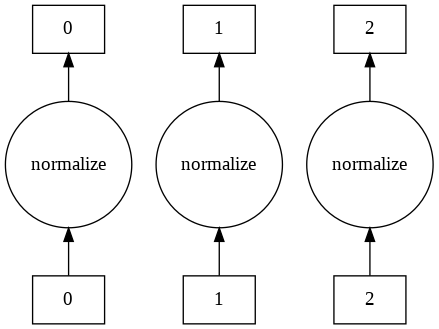

In [35]:
dask.visualize(clean_body_train)

In [36]:
more_text = clean_body_train.compute()


In [37]:
more_text[0]

'i rented i am curious yellow video store surrounded released i heard tried enter country fan films considered controversial i plot centered young swedish drama student named lena wants learn life in particular wants focus making sort documentary average thought certain political issues vietnam war race issues united states in asking ordinary opinions politics sex drama teacher married kills i am curious yellow 40 years ago considered really sex nudity scenes far shot like porno while mind find shocking reality sex nudity major swedish cinema even bergman arguably answer good old boy john ford sex scenes filmmakers fact sex shown film shown artistic purposes shock people money shown theaters america i am curious yellow good film wanting study meat intended swedish cinema but film plot'

In [38]:
reviews_list_test = data['test']['without_stopwords_reviews']
review_bag_test = db.from_sequence(reviews_list_test, npartitions=3)
clean_body_test = review_bag_test.map(normalize,top_5000_words=top_5000_words)


In [39]:
more_text_test = clean_body_test.compute()

In [40]:
more_text_test[0]

"i love sci fi willing lot sci fi movies tv usually appreciated i tried like i good tv sci fi 5 star trek original silly cheap cardboard sets stilted dialogues cg match background painfully dimensional characters overcome ' sci fi ' setting i sure think 5 good sci fi tv it it clichéd while us viewers like emotion character development sci fi genre seriously star trek it treat important issues philosophy it difficult care characters simply missing life their actions reactions wooden predictable painful watch the makers earth know rubbish gene earth people continue watching turning dull cheap poorly edited watching breaks brings home space spoiler so kill main character and bring actor"

In [41]:
data['train'] = data['train'].add_column(name="cleaned_reviews", column=more_text)
data['test'] = data['test'].add_column(name="cleaned_reviews", column=more_text_test)

In [71]:
data['train']['cleaned_reviews'][10]

'it great favorite stars 30 years ago including john ritter ben they looked wonderful but they given characters good lines work i understood cared characters smaller female roles fine camp competent small sidekick parts they showed talent sad star better films sadly i think dorothy got chance act important film film appears fans i open minded i started watching i big peter fan i enjoyed movie cat early ones so surprised i barely able awake watching ironic movie detective involved five years later ex girlfriend hit television series called stealing story idea of course great difference series tons witty dialogue tries slapstick line it ai paper moon version what up doc'

In [43]:
data['test']['cleaned_reviews'][0]

"i love sci fi willing lot sci fi movies tv usually appreciated i tried like i good tv sci fi 5 star trek original silly cheap cardboard sets stilted dialogues cg match background painfully dimensional characters overcome ' sci fi ' setting i sure think 5 good sci fi tv it it clichéd while us viewers like emotion character development sci fi genre seriously star trek it treat important issues philosophy it difficult care characters simply missing life their actions reactions wooden predictable painful watch the makers earth know rubbish gene earth people continue watching turning dull cheap poorly edited watching breaks brings home space spoiler so kill main character and bring actor"

In [44]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews', 'cleaned_reviews'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews', 'cleaned_reviews'],
        num_rows: 25000
    })
})

## Tokenizing

In [45]:
from transformers import AutoTokenizer

In [46]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [104]:
def tokenize_fn(batch):
  return tokenizer(batch['cleaned_reviews'], truncation=True,padding='max_length',max_length=512) #no padding option since it will be handled by the trainer in thsi case
tokenized_dataset = data.map(tokenize_fn, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [105]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

## Embeddings Last Hidden State (features)
- These Embeddings will be common to all architecture

In [106]:
from transformers import AutoModel
checkpoint = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(checkpoint).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
tokenized_dataset['train']['input_ids'][0]

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names and isinstance(v, list)==False}
  # Extract Last Hidden State 
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  #Return Vector for [CLS] token
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}


In [111]:
tokenized_dataset.set_format("torch", columns=['input_ids', 'attention_mask','label'])

In [112]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'without_stopwords_reviews', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [113]:
tokenized_hidden_states = tokenized_dataset.map(extract_hidden_states, batched=True, batch_size=16)

  0%|          | 0/1563 [00:00<?, ?ba/s]

  0%|          | 0/1563 [00:00<?, ?ba/s]

In [114]:
tokenized_hidden_states['train']['hidden_state'].shape

torch.Size([25000, 768])

In [115]:
tokenized_hidden_states['test']['hidden_state'].shape

torch.Size([25000, 768])

## Train and Test Data 

In [116]:
X_train = np.array(tokenized_hidden_states['train']["hidden_state"])
y_train = np.array(tokenized_hidden_states['train']["label"])
X_valid = np.array(tokenized_hidden_states['test']["hidden_state"])
y_valid = np.array(tokenized_hidden_states['test']["label"])

## DistilBERT Embeddings + Logistic Regression

#### Logistic Regression Model 

In [117]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=3000)
lr.fit(X_train,y_train)
preds = lr.predict(X_valid)

#### Performance Metric

In [118]:
cm = confusion_matrix(y_valid, preds, labels=[0, 1])

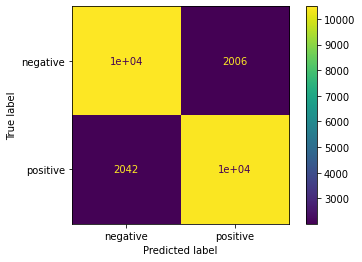

In [119]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [120]:
print(classification_report(y_valid,preds))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## DistilBERT Embeddings + ANN Head 

#### Model Architecture for ANN

In [121]:
model = Sequential()
model.add(Dense(768, activation='relu', kernel_initializer='normal', input_shape=(768,)))
#model.add(Dropout(0.2))
model.add(Dense(600,kernel_initializer='normal', activation='relu'))
model.add(Dense(600,kernel_initializer='normal', activation='relu'))
#model.add(Dense(19,kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 768)               590592    
                                                                 
 dense_1 (Dense)             (None, 600)               461400    
                                                                 
 dense_2 (Dense)             (None, 600)               360600    
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1)                 601       
                                                                 
Total params: 1,415,593
Trainable params: 1,414,393
Non-trainable params: 1,200
__________________________________________

In [122]:
model.compile(
  loss=tf.keras.losses.binary_crossentropy,
  optimizer=tf.keras.optimizers.Adam(lr=0.001),
  metrics=['accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 768)               590592    
                                                                 
 dense_1 (Dense)             (None, 600)               461400    
                                                                 
 dense_2 (Dense)             (None, 600)               360600    
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1)                 601       
                                                                 
Total params: 1,415,593
Trainable params: 1,414,393
Non-trainable params: 1,200
__________________________________________

In [123]:
X_train.shape

(25000, 768)

#### Model Training 

In [124]:
r = model.fit(X_train,
        y_train,
        batch_size=128,
  epochs=40,
  validation_data=(X_valid, y_valid)
)  

Epoch 1/40
196/196 [==============================] - 5s 7ms/step - loss: 0.4323 - accuracy: 0.8065 - val_loss: 0.5179 - val_accuracy: 0.7476
Epoch 2/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3936 - accuracy: 0.8264 - val_loss: 0.4191 - val_accuracy: 0.8108
Epoch 3/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3895 - accuracy: 0.8275 - val_loss: 0.3989 - val_accuracy: 0.8210
Epoch 4/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3832 - accuracy: 0.8318 - val_loss: 0.6437 - val_accuracy: 0.7102
Epoch 5/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3790 - accuracy: 0.8341 - val_loss: 0.3881 - val_accuracy: 0.8279
Epoch 6/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3760 - accuracy: 0.8372 - val_loss: 0.3842 - val_accuracy: 0.8263
Epoch 7/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3743 - accuracy: 0.8326 - val_loss: 0.4026 - val_accuracy: 0.8200
Epoch 

#### Model Validation

In [125]:
preds_ann = model.predict(X_valid)

In [126]:
y_valid.shape

(25000,)

In [127]:
preds_ann = np.where(preds_ann>0.5,1,0).reshape(y_valid.shape)

In [128]:
preds_ann

array([0, 0, 0, ..., 0, 0, 1])

In [129]:
cm = confusion_matrix(y_valid, preds_ann, labels=[0, 1])

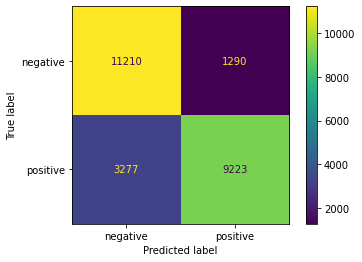

In [130]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [131]:
print(classification_report(y_valid,preds_ann))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83     12500
           1       0.88      0.74      0.80     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



## DistilBERT Embeddings + CNN Model Concatenation

In [132]:
from transformers import AutoConfig

#### Preparing the inputs for CNN

In [133]:
X_train_cnn = X_train.reshape(25000,768,1)
X_test_cnn = X_valid.reshape(25000,768,1)

In [134]:
X_train_cnn.shape

(25000, 768, 1)

In [135]:
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout, SpatialDropout1D, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

##SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF


#### Model Architecture for CNN (using concatenation of CNN Layers)

In [136]:
input_ = Input(shape=(768,1))


conv1 = Conv1D(256, 20,strides=1, activation='relu')(input_)
maxp_1 = GlobalMaxPool1D(name='maxp_1')(conv1)

conv2= Conv1D(256, 10, activation='relu' )(input_)
maxp_2 = GlobalMaxPool1D(name='maxp_2')(conv2)

conv3= Conv1D(256, 5, activation='relu' )(input_)
maxp_3 = GlobalMaxPool1D(name='maxp_3')(conv3)

concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(64, activation='relu', name='dense')(concat)


output = Dense(1, activation="sigmoid")(dense_layer)
#output = dense(dense_layer)
model = Model(input_, output)



In [137]:
model.compile(
  loss=tf.keras.losses.binary_crossentropy,
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  metrics=['accuracy']
)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 749, 256)     5376        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 759, 256)     2816        ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 764, 256)     1536        ['input_1[0][0]']                
                                                                                              

In [138]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

#### Model Training 

In [139]:
r = model.fit(X_train_cnn,
        y_train,
        batch_size=64,
  epochs=10,
  callbacks=callbacks,
  validation_data=(X_test_cnn, y_valid)
)  

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.6068
Epoch 1: val_loss improved from inf to 0.65866, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5
391/391 [==============================] - 15s 15ms/step - loss: 0.6753 - accuracy: 0.6068 - val_loss: 0.6587 - val_accuracy: 0.6594
Epoch 2/10
390/391 [============================>.] - ETA: 0s - loss: 0.6403 - accuracy: 0.6687
Epoch 2: val_loss improved from 0.65866 to 0.62574, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5
391/391 [==============================] - 6s 14ms/step - loss: 0.6402 - accuracy: 0.6689 - val_loss: 0.6257 - val_accuracy: 0.6747
Epoch 3/10
388/391 [============================>.] - ETA: 0s - loss: 0.6075 - accuracy: 0.6896
Epoch 3: val_loss improved from 0.62574 to 0.59398, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5
391/391 [==============================] - 6s 14ms/step - loss: 0.6074 - accuracy: 0.689

#### Model Accuracy

In [161]:
from tensorflow.keras.models import load_model
cnn = load_model('/content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5')


In [162]:
preds_cnn=cnn.predict(X_valid)

In [163]:
preds_cnn = np.where(preds_cnn>0.5,1,0).reshape(y_valid.shape)

In [164]:
cm = confusion_matrix(y_valid, preds_cnn, labels=[0, 1])

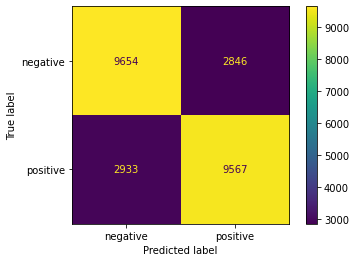

In [165]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [166]:
print(classification_report(y_valid,preds_cnn))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     12500
           1       0.77      0.77      0.77     12500

    accuracy                           0.77     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.77      0.77      0.77     25000



## DistilBERT Embedding + CNN Suquential 

#### Model Architecture 

In [167]:
input_ = Input(shape=(768,1))


conv1 = Conv1D(256, 20,strides=1, activation='relu')(input_)
maxp_1 = GlobalMaxPool1D(name='maxp_1')(conv1)

conv2= Conv1D(128, 10, activation='relu' )(conv1)
maxp_2 = GlobalMaxPool1D(name='maxp_2')(conv2)

#conv3= Conv1D(256, 5, activation='relu' )(input_)
#maxp_3 = GlobalMaxPool1D(name='maxp_3')(conv3)

#concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(128, activation='relu', name='dense')(maxp_2)


output = Dense(1, activation="sigmoid")(dense_layer)
#output = dense(dense_layer)
model2_cnn = Model(input_, output)


In [168]:
model2_cnn.compile(
  loss=tf.keras.losses.binary_crossentropy,
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  metrics=['accuracy']
)
print(model2_cnn.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 749, 256)          5376      
                                                                 
 conv1d_6 (Conv1D)           (None, 740, 128)          327808    
                                                                 
 maxp_2 (GlobalMaxPooling1D)  (None, 128)              0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 349,825
Trainable params: 349,825
Non-trainab

In [169]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

#### Model Training 

In [170]:
r = model2_cnn.fit(X_train_cnn,
        y_train,
        batch_size=64,
  epochs=15,
  callbacks=callbacks,
  validation_data=(X_test_cnn, y_valid)
)  

Epoch 1/15
386/391 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.6543
Epoch 1: val_loss improved from inf to 0.56493, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5
391/391 [==============================] - 6s 15ms/step - loss: 0.6377 - accuracy: 0.6552 - val_loss: 0.5649 - val_accuracy: 0.7206
Epoch 2/15
388/391 [============================>.] - ETA: 0s - loss: 0.5034 - accuracy: 0.7602
Epoch 2: val_loss improved from 0.56493 to 0.46890, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5
391/391 [==============================] - 6s 14ms/step - loss: 0.5036 - accuracy: 0.7601 - val_loss: 0.4689 - val_accuracy: 0.7818
Epoch 3/15
388/391 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.7905
Epoch 3: val_loss improved from 0.46890 to 0.44273, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5
391/391 [==============================] - 6s 15ms/step - loss: 0.4532 - accu

In [171]:
from tensorflow.keras.models import load_model
cnn2 = load_model('/content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5')



#### Model Metrics

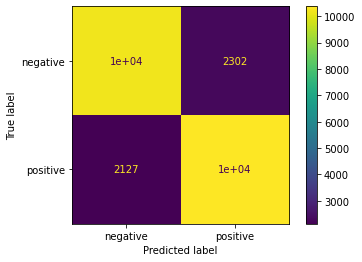

In [172]:
preds_cnn2 = cnn2.predict(X_valid)
preds_cnn2 = np.where(preds_cnn2>0.5,1,0).reshape(y_valid.shape)
cm = confusion_matrix(y_valid, preds_cnn2, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [173]:
print(classification_report(y_valid,preds_cnn2))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     12500
           1       0.82      0.83      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

